`python3 -m pip install -U pandas plotly nbformat networkx`

`pip install "https://github.com/DCMLab/wavescapes/archive/refs/heads/johannes.zip"`

In [ ]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
 
import etl
import utils

from wavescapes.color import circular_hue

## Settings

In [48]:
DEBUSSY_REPO = os.path.join('..','..','debussy')
DATA_FOLDER = os.path.join(DEBUSSY_REPO, 'data')
EXAMPLE_FNAME = 'l000_etude'
LONG_FORMAT = False

## Loading metadata
Metadata for all pieces contained in the dataset.

In [49]:
metadata = etl.get_metadata(DEBUSSY_REPO)
metadata.columns

Metadata for 82 files.


Index(['rel_paths', 'last_mc', 'last_mn', 'length_qb', 'length_qb_unfolded',
       'all_notes_qb', 'n_onsets', 'TimeSig', 'KeySig', 'label_count',
       'composer', 'workTitle', 'movementNumber', 'movementTitle',
       'workNumber', 'poet', 'lyricist', 'arranger', 'copyright',
       'creationDate', 'mscVersion', 'platform', 'source', 'translator',
       'musescore', 'ambitus', 'comment', 'comments', 'composed_end',
       'composed_start', 'originalFormat', 'pdf', 'staff_1_ambitus',
       'staff_1_instrument', 'staff_2_ambitus', 'staff_2_instrument',
       'staff_3_ambitus', 'staff_3_instrument', 'transcriber', 'typesetter',
       'year', 'median_recording', 'qb_per_minute', 'sounding_notes_per_qb',
       'sounding_notes_per_minute'],
      dtype='object')

The column `year` contains composition years as the middle between beginning and end  of the composition span.

In [50]:
metadata.year.head(10)

fnames
l000_etude                     1915.0
l000_soirs                     1917.0
l009_danse                     1880.0
l066-01_arabesques_premiere    1888.0
l066-02_arabesques_deuxieme    1891.0
l067_mazurka                   1890.0
l068_reverie                   1890.0
l069_tarentelle                1890.0
l070_ballade                   1890.0
l071_valse                     1890.0
Name: year, dtype: float64

Series `median_recording` contains median recording times in seconds, retrieved from the Spotify API. the Spotify API.

In [51]:
metadata.median_recording.head(10)

fnames
l000_etude                     272.5530
l000_soirs                     145.8265
l009_danse                     124.5995
l066-01_arabesques_premiere    240.7780
l066-02_arabesques_deuxieme    213.9330
l067_mazurka                   175.9130
l068_reverie                   265.4265
l069_tarentelle                331.5290
l070_ballade                   396.0200
l071_valse                     221.4500
Name: median_recording, dtype: float64

Columns mirroring a piece's activity are currently:
* `qb_per_minute`: the pieces' lengths (expressed as 'qb' = quarterbeats) normalized by the median recording times; a proxy for the tempo
* `sounding_notes_per_minute`: the summed length of all notes normalized by the piece's duration (in minutes)
* `sounding_notes_per_qb`: the summed length of all notes normalized by the piece's length (in qb)
Other measures of activity could be, for example, 'onsets per beat/second' or 'distinct pitch classes per beat/second'.

## Loading Pitch Class Vectors (PCVs)
An `{fname -> pd.DataFrame}` dictionary where each `(NX12)` DataFrame contains the absolute durations (expressed in quarter nots) of the 12 chromatic pitch classes for the `N` slices of length = 1 quarter note that make up the piece `fname`. The IntervalIndex reflects each slice's position in the piece. Set `pandas` to False to retrieve NumPy arrays without the IntervalIndex and column names.

In [52]:
pcvs = etl.get_pcvs(DEBUSSY_REPO, pandas=True)
etl.test_dict_keys(pcvs, metadata)
pcvs[EXAMPLE_FNAME].head(5)

Found matrices for all files listed in metadata.tsv.


,0,1,2,3,4,5,6,7,8,9,10,11
iv,,,,,,,,,,,,
"[0.0, 1.0)",0.16667,0.0,0.0,0.33333,0.0,0.00000,0.0,0.0,1.33333,0.0,0.16667,0.0
"[1.0, 2.0)",0.16667,0.0,0.0,0.33333,0.0,0.33333,0.0,0.0,1.16667,0.0,0.00000,0.0
"[2.0, 3.0)",0.16667,0.0,0.0,0.33333,0.0,0.33333,0.0,0.0,0.16667,0.0,0.00000,0.0
"[3.0, 4.0)",0.16667,0.0,0.0,0.33333,0.0,0.33333,0.0,0.0,0.16667,0.0,0.00000,0.0
"[4.0, 5.0)",0.16667,0.0,0.0,0.33333,0.0,0.33333,0.0,0.0,1.16667,0.0,0.00000,0.0


## Loading Pitch Class Matrices
An `{fname -> np.array}` dictionary where each `(NxNx12)` array contains the aggregated PCVs for all segments that make up a piece. The square matrices contain values only in the upper right triangle, with the lower left beneath the diagonal is filled with zeros. The values are arranged such that row 0 correponds to the original PCV, row 1 the aggregated PCVs for all segments of length = 2 quarter notes, etc. For getting the segment reaching from slice 3 to 5 (including), i.e. length 3, the coordinates are `(2, 5)` (think x = 'length - 1' and y = index of the last slice included). The following example shows the upper left 3x3 submatrix where the first three entries (which are PCVs of size 12) correspond to the first three PCVs above, the first three of the second row to their sums padded with a 0-PCV, and the first three of the third row corresponding to the sum of row 0, padded with another 0-PCV.

In [53]:
pcms = etl.get_pcms(DEBUSSY_REPO, long=LONG_FORMAT)
etl.test_dict_keys(pcms, metadata)
pcms[EXAMPLE_FNAME].shape

Found matrices for all files listed in metadata.tsv.


(284, 284, 12)

## Loading Discrete Fourier Transforms
`{fname -> np.array}` containing `(NxNx7)` complex matrices. For instance, here's the first element, a size 7 complex vector with DFT coefficients 0 through 6:

In [54]:
dfts = etl.get_dfts(DEBUSSY_REPO, long=LONG_FORMAT)
etl.test_dict_keys(dfts, metadata)
dfts[EXAMPLE_FNAME].shape

Found matrices for all files listed in metadata.tsv.


(284, 284, 7)

You can view the 7 complex numbers as magnitude-phase pairs

In [57]:
utils.get_coeff(dfts[EXAMPLE_FNAME], 0, 0)

array([[ 2.  ,  0.  ],
       [ 1.05,  1.98],
       [ 1.36, -2.31],
       [ 1.37,  0.24],
       [ 1.04,  1.81],
       [ 1.68, -1.82],
       [ 1.33,  0.  ]])

or even as strings where the numbers are rounded and angles are shown in degrees:

In [58]:
utils.get_coeff(dfts[EXAMPLE_FNAME], 0, 0, deg=True)

array([['2.0+0°'],
       ['1.05+247°'],
       ['1.36+132°'],
       ['1.37+346°'],
       ['1.04+256°'],
       ['1.68+104°'],
       ['1.33+0°']], dtype='<U9')

## Loading magnitude-phase matrices
`{fname -> np.array}` where each of the `(NxNx6x2)` matrices contains the 6 relevant DFT coefficients converted into magnitude-phase pairs where the magnitudes have undergone at least one normalization, i.e. are all within [0,1]. The files have been pre-computed and are loaded from g-zipped pickled matrices.

The parameter `norm_params` can be one or several `(how, indulge)` pairs where `indulge` is a boolean and `how ∈ {'0c', 'post_norm', 'max_weighted', 'max'}`.

In [59]:
norm_params = ('0c', True)
mag_phase_mx_dict = etl.get_mag_phase_mx(DATA_FOLDER, norm_params=norm_params, long=LONG_FORMAT)
etl.test_dict_keys(mag_phase_mx_dict, metadata)
mag_phase_mx_dict[EXAMPLE_FNAME].shape

Found matrices for all files listed in metadata.tsv.


(284, 284, 6, 2)

In [60]:
mpm = mag_phase_mx_dict[EXAMPLE_FNAME]
colors = circular_hue(mpm[...,1,:], output_rgba=True, ignore_phase=True)
colors.shape

(284, 284)

Note that the phases (2nd column) are the same that we inspected above via `get_coeff()` whereas the magnitudes are now normalized by the first (now absent) coefficient 0.

In [61]:
mag_phase_mx_dict[EXAMPLE_FNAME][0]

array([[[ 5.38214271e-01,  1.97790855e+00],
        [ 7.49750250e-01, -2.30792065e+00],
        [ 8.33166833e-01,  2.45331397e-01],
        [ 7.49750250e-01,  1.81282734e+00],
        [ 8.71880604e-01, -1.82039166e+00],
        [ 6.66333666e-01,  8.32251143e-17]],

       [[ 4.44424363e-01,  2.51616207e+00],
        [ 4.99500500e-01, -2.25090725e+00],
        [ 6.66333666e-01,  0.00000000e+00],
        [ 1.00000000e+00,  1.76042734e+00],
        [ 7.72101656e-01, -1.65477615e+00],
        [ 3.32667333e-01,  8.33500769e-17]],

       [[ 4.10683603e-01, -2.09439510e+00],
        [ 1.66666667e-01,  2.09439510e+00],
        [ 3.33333333e-01,  0.00000000e+00],
        [ 1.00000000e+00,  1.04719755e+00],
        [ 7.44016936e-01, -1.04719755e+00],
        [ 3.33333333e-01, -3.14159265e+00]],

       ...,

       [[ 1.78632795e-01, -2.61799388e-01],
        [ 3.33333333e-01, -2.09439510e+00],
        [ 1.00000000e+00,  4.63647609e-01],
        [ 1.00000000e+00,  5.23598776e-01],
        [ 6.6

## Loading most resonant DFT coefficients
This cell depends on the previously loaded magnitude-phase matrices, i.e. a conscious choice of a normalization method has been made above.

`get_most_resonant` returns three `{fname -> nd.array}` dictionaries where for each piece, the three `(NxN)` matrices correspond to

1. the index between 0 and 5 of the most resonant of the six DFT coefficient 1 through 6
2. its magnitude
3. the inverse entropy of the 6 magnitudes

In [62]:
max_coeffs, max_mags, inv_entropies = etl.get_most_resonant(mag_phase_mx_dict, )
np.column_stack((max_coeffs[EXAMPLE_FNAME][:3],
max_mags[EXAMPLE_FNAME][:3],
inv_entropies[EXAMPLE_FNAME][:3]))

c:\Users\ludov\anaconda3\envs\ada\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


array([[4.        , 3.        , 3.        , ..., 0.18687664, 0.18687664,
        0.18687664],
       [0.        , 3.        , 3.        , ..., 0.18687664, 0.18687664,
        0.18687664],
       [0.        , 0.        , 3.        , ..., 0.24929173, 0.18687664,
        0.18687664]])

# Metrics

In this section, we compile a dataframe containing all metrics results, both melted and not. The metrics will then be stored and used for testing in RFILE. Optional plots and tests can be done by adjusting the parameters of the wrapper function `get_metric` that can be found in `etl.py`. 

In [63]:
# let's start from the available metadata for each piece
metadata_metrics = metadata.copy()

# Prevalence of each coefficient

Prevalence of coefficient $n$ in a piece: $W(n)=1/N \sum_{i \in S(n)} i$ where $N$ is the total number of nodes in the wavescape, $S(n)$ is the set of the indices of the nodes in the summary wavescapes that are attributed to coefficient $n$ (i.e., where coefficient $n$ is the most prominent among the six).

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.99692521 0.00210772 0.15537592 0.32255505 0.51909343 0.00394267]


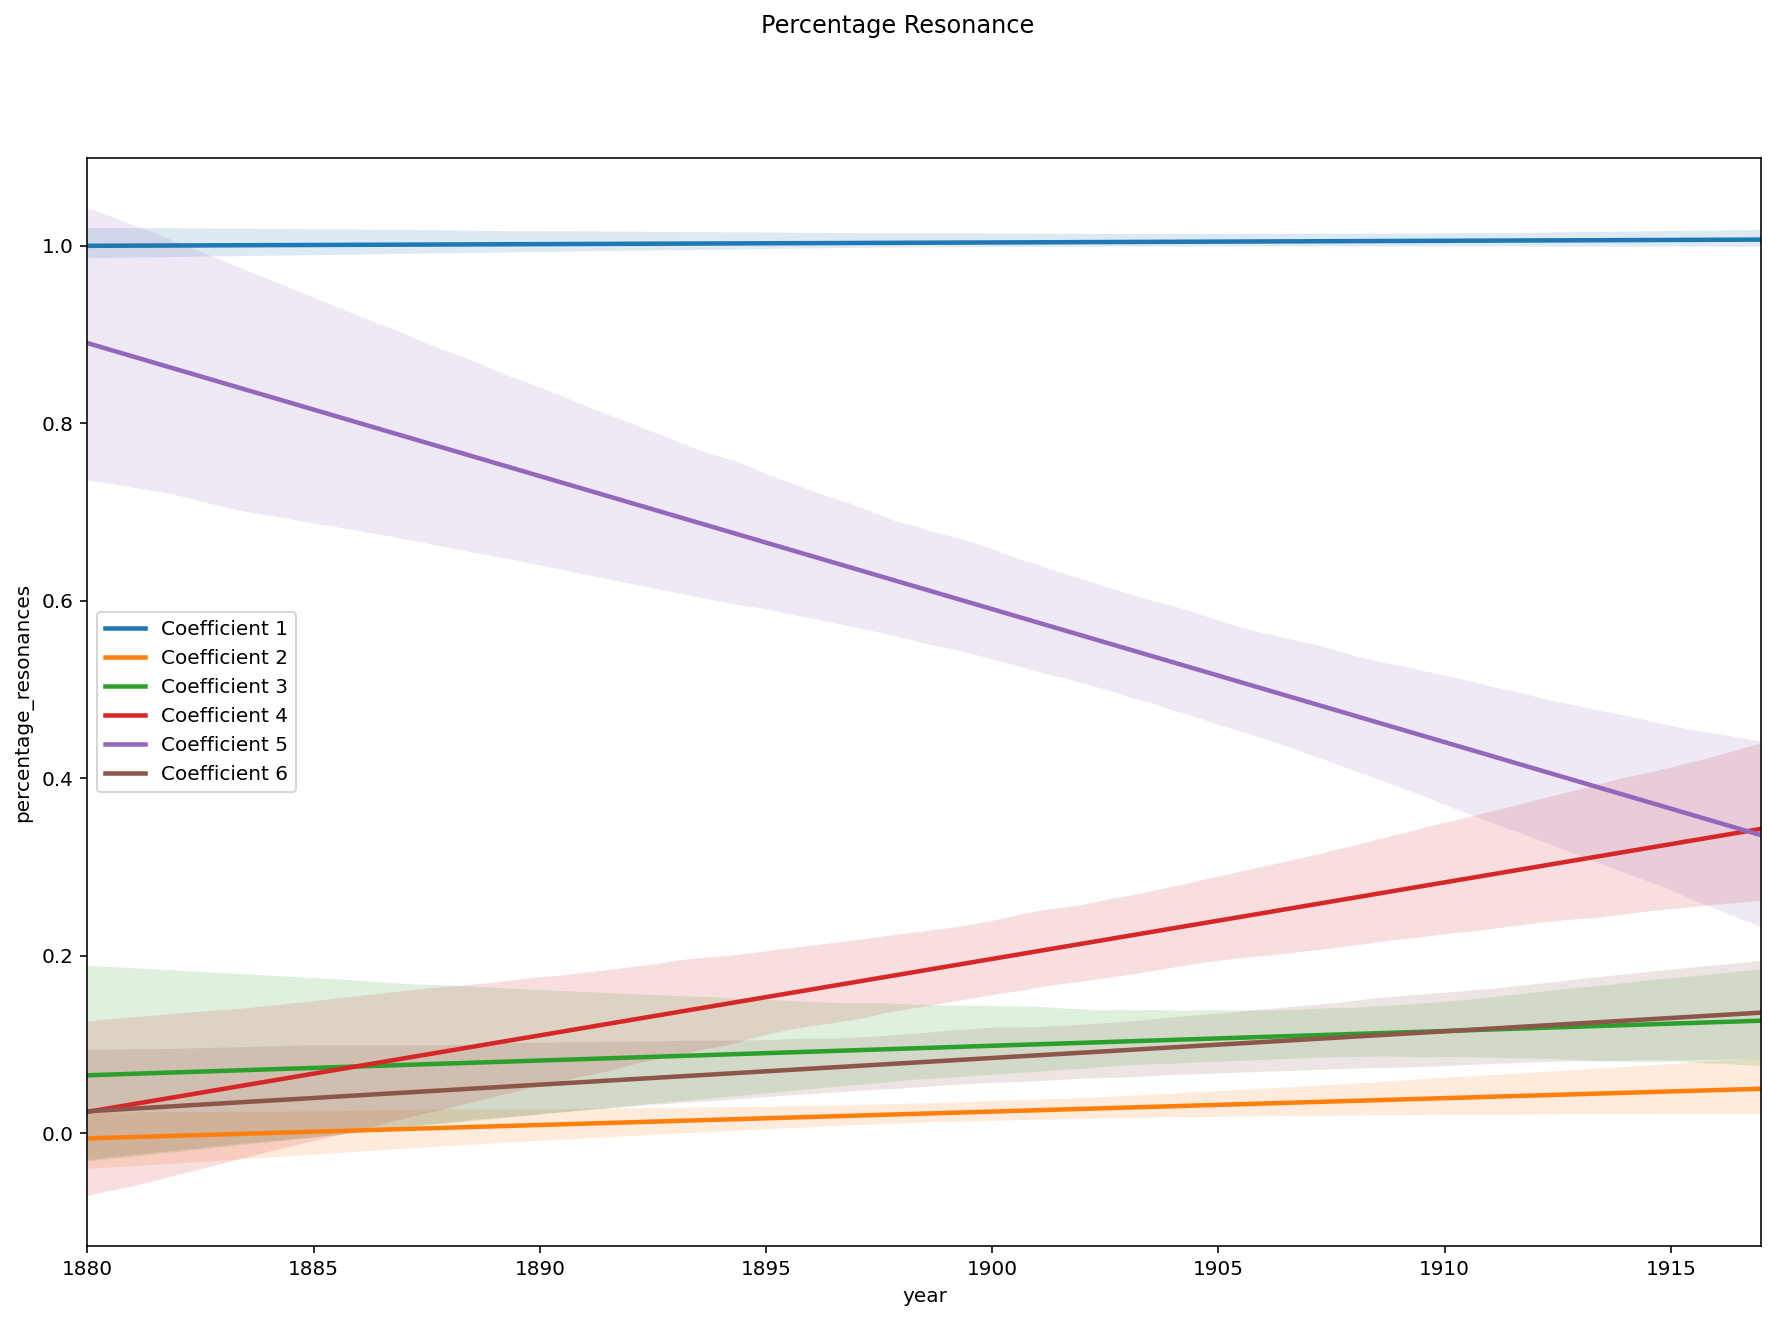

In [65]:
# defining column names
cols = [f"percentage_resonances_{i}" for i in range(1,7)]

metadata_metrics = etl.get_metric('percentage_resonance', metadata_metrics, 
                              max_coeffs=max_coeffs, cols=cols, 
                              store_matrix=True, show_plot=True, unified=True,
                              save_name='percentage_resonance', title='Percentage Resonance')

In [43]:
metadata_metrics[cols].head()

,percentage_resonances_1,percentage_resonances_2,percentage_resonances_3,percentage_resonances_4,percentage_resonances_5,percentage_resonances_6
l000_etude,0.996925,0.002108,0.155376,0.322555,0.519093,0.003943
l000_soirs,0.988764,0.007322,0.245929,0.187098,0.530236,0.040651
l009_danse,0.994687,0.001691,0.072334,0.055730,0.874653,0.000906
l066-01_arabesques_premiere,0.997669,0.000436,0.084816,0.024915,0.889839,0.002325
l066-02_arabesques_deuxieme,0.999435,0.000537,0.050853,0.038392,0.813080,0.097703


In order to account for the certainty that a certain coefficient is actually the most resonance, we weigh the previous metric by entropy as follows: $W(n)=1/N \sum_{i \in S(n)} w_i$ where $N$ is the total number of nodes in the wavescape, $S(n)$ is the set of the indices of the nodes in the summary wavescapes that are attributed to coefficient $n$ (i.e., where coefficient $n$ is the most prominent among the six), and $w_i$ is the weight (opacity) of the $i$-th node in the summary wavescape, in this case, the entropy of $i$.



Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [3.68269427e-05 3.44656566e-04 3.62538535e-02 7.46800853e-02
 1.13474114e-01 5.84514693e-04]


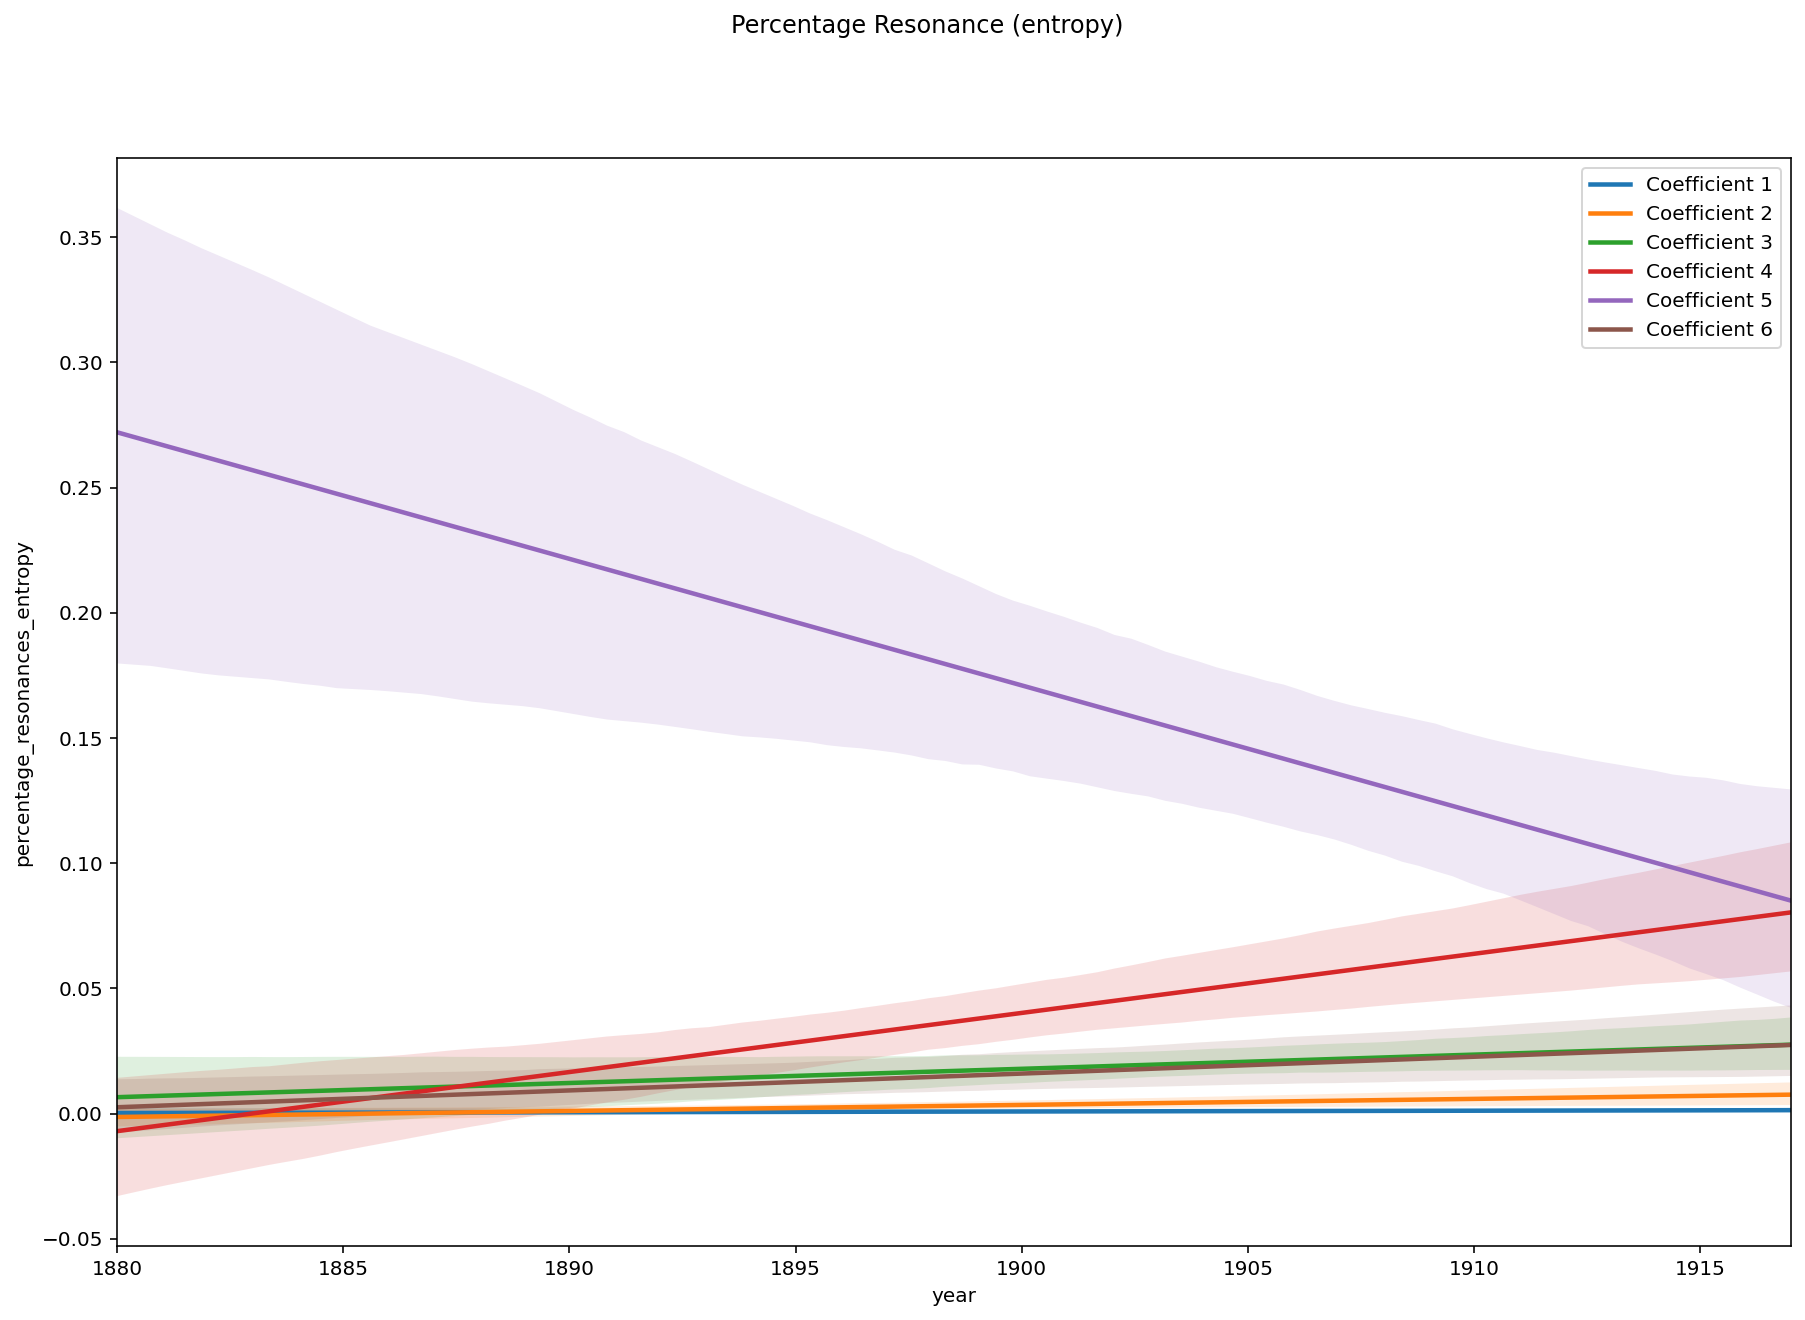

In [66]:
cols = [f"percentage_resonances_entropy_{i}" for i in range(1,7)]

metadata_metrics = etl.get_metric('percentage_resonance_entropy', metadata_metrics, 
                              cols=cols,
                              max_coeffs=max_coeffs, inv_entropies=inv_entropies,
                              store_matrix=True, show_plot=True, unified=True,
                              save_name='percentage_resonance_entropy', title='Percentage Resonance (entropy)')

In [67]:
metadata_metrics[cols].head()

,percentage_resonances_entropy_1,percentage_resonances_entropy_2,percentage_resonances_entropy_3,percentage_resonances_entropy_4,percentage_resonances_entropy_5,percentage_resonances_entropy_6
l000_etude,3.682694e-05,0.000345,0.036254,0.074680,0.113474,0.000585
l000_soirs,0.000000e+00,0.002272,0.059224,0.043886,0.096476,0.009224
l009_danse,8.330704e-06,0.000344,0.018773,0.012027,0.305494,0.000147
l066-01_arabesques_premiere,8.072669e-21,0.000050,0.031577,0.005141,0.433300,0.000272
l066-02_arabesques_deuxieme,1.744510e-04,0.000063,0.009566,0.008244,0.225798,0.010613


# Post-hoc analysis of hierarchical prevalence
## Moment of Inertia

Moment of inertia of coefficient $n$ in the summary wavescape: $I(n)=1/N \sum_{i \in S(n)} w_i y_i^2$, where N is the total number of nodes in the wavescape, $S(n)$ is the set of the indices of the nodes in the summary wavescapes that are attributed to coefficient $n$ (i.e., where coefficient n is the most prominent among the six), $w_i$ is the weight (opacity) of the $i$-th node in the summary wavescape, and $y_i$ is the vertical coordinate of the $i$-th node in the summary wavescape


Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [1.90132927e-08 3.42032095e-06 4.49496960e-03 6.55152625e-03
 3.26146744e-02 2.60299197e-05]


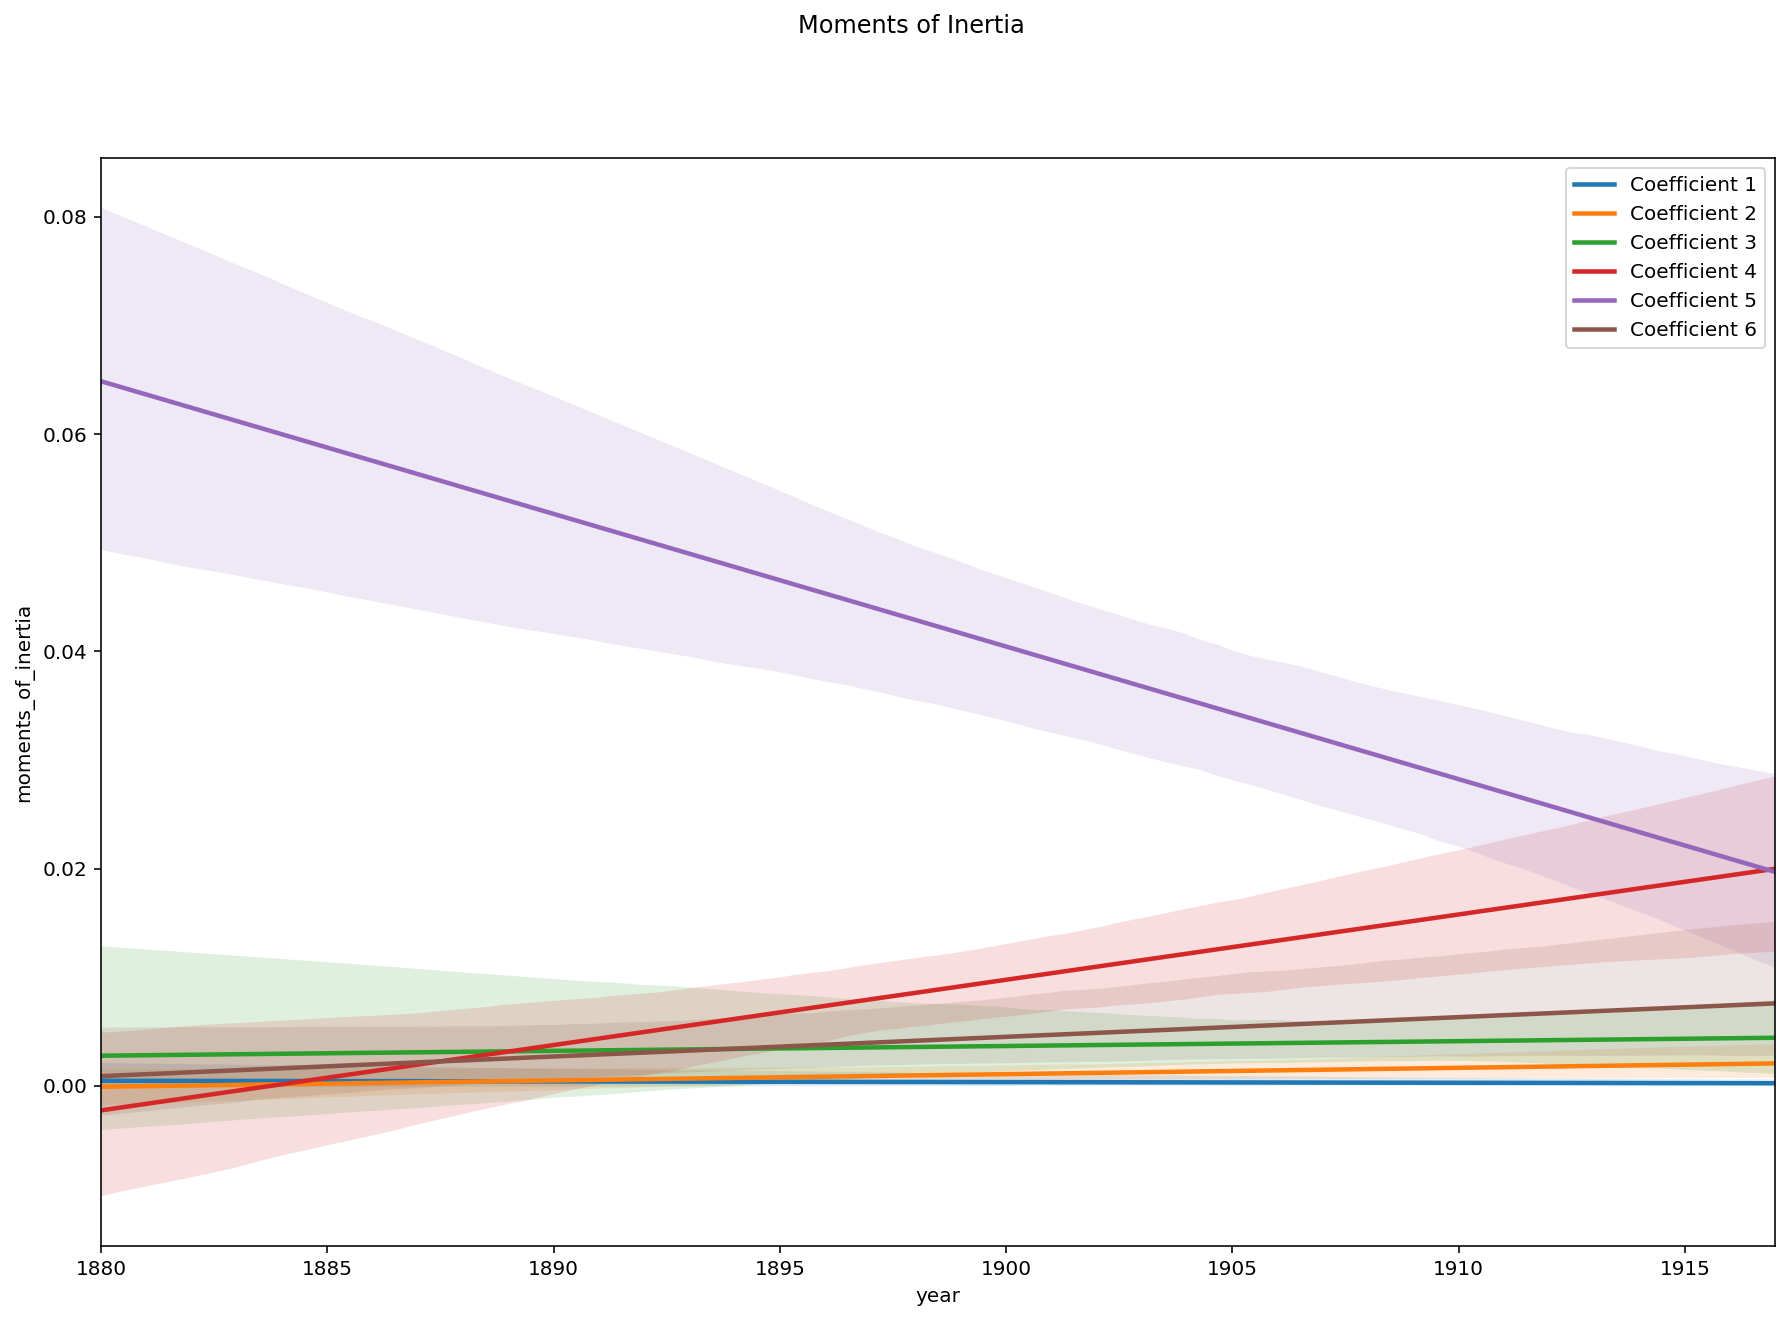

In [68]:
cols = [f"moments_of_inertia_{i}" for i in range(1,7)]

metadata_metrics = etl.get_metric('moment_of_inertia', metadata_metrics, 
                              cols=cols,
                              max_coeffs=max_coeffs, max_mags=max_mags,
                              store_matrix=True, show_plot=True, unified=True,
                              save_name='moments_of_inertia', title='Moments of Inertia')

In [69]:
metadata_metrics[cols].head()

,moments_of_inertia_1,moments_of_inertia_2,moments_of_inertia_3,moments_of_inertia_4,moments_of_inertia_5,moments_of_inertia_6
l000_etude,1.901329e-08,3.420321e-06,0.004495,0.006552,0.032615,2.602992e-05
l000_soirs,0.000000e+00,7.947701e-06,0.005587,0.004772,0.050804,3.869456e-04
l009_danse,0.000000e+00,8.480699e-07,0.000796,0.000161,0.069731,5.954237e-08
l066-01_arabesques_premiere,6.246957e-10,4.847618e-09,0.001685,0.000014,0.071805,3.210856e-07
l066-02_arabesques_deuxieme,1.366886e-06,5.411086e-08,0.000481,0.000034,0.058306,1.976220e-03


# Measure Theoretic Entropy

Measure-theoretic entropy: Let $A={A_1,...,A_k}$ be a (finite) partition of a probability space $(X,P(X),)$: the entropy of the partition $A$ is defined as $H(A)= - \sum_{i} \mu(A_i) \log \mu(A_i)$. We can take $X$ as the support of the wavescape, $A$ as the set of the connected regions in the unified wavescape, and $\mu(Y)=(area-of-Y)/(area-of-X)$ for any subset $Y$ of the wavescape.


In [70]:
cols = 'partition_entropy'

metadata_metrics = etl.get_metric('partition_entropy', metadata_metrics, 
                              cols=cols,
                              max_coeffs=max_coeffs,
                              store_matrix=True, scatter=True, show_plot=True, unified=True, 
                              save_name='partition_entropy', title='Partition Entropy')

In [ ]:
metadata_metrics[cols].head()

# Decreasing magnitude in height

The inverse coherence is the slope of the regression line that starts from the magnitude resonance in the summary wavescape at bottom of the wavescape and reaches the one at the top of the wavescape.

In [ ]:
cols = 'inverse_coherence'
metadata_metrics = etl.get_metric('inverse_coherence', metadata_metrics, 
                              cols=cols,
                              max_mags=max_mags,
                              store_matrix=True, show_plot=True, unified=True, scatter=True,
                              save_name='inverse_coherence', title='Inverse Coherence')

In [ ]:
metadata_metrics[cols].head()

# Storing the final metrics files

In [ ]:
if not os.path.isdir('results'):
    os.makedirs('results')

metadata_metrics.reset_index().to_csv('results/results.csv', index=False)

In [ ]:
# melting the results to be used for testing on coefficient specific metrics

cols = [col for col in metadata_metrics.columns if col[-1].isnumeric()]
metadata_melted = pd.melt(metadata_metrics, id_vars=['fname', 'length_qb', 'year', 'last_mc'], value_vars=cols)

metadata_melted.reset_index().to_csv('results/results_melted.csv', index=False)